# Model Refinement / Testing
* Gussian Niave Bayes Model - KBest Selector 

In [3]:
#Load Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

import os, sys
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import  confusion_matrix,classification_report,precision_recall_curve

### Database Connection

In [4]:
import getpass

mypasswd = getpass.getpass()

········


In [5]:
import psycopg2
import pandas as pd
import numpy as np
from psycopg2.extensions import adapt, register_adapter, AsIs

# Then connects to the DB
connection = psycopg2.connect(database = 'capstonesp23olt05', 
                              user = 'cad7v7', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

cursor = connection.cursor()

In [6]:
del mypasswd

### Database Query Data Validation

In [7]:
# Selecting one year from the weekly running stats table to view columns

select_statement = f"""
SELECT *
FROM team_weekly_stats_running
WHERE gametime_day >= '2021-07-01' 
AND gametime_day <='2022-07-01'
"""

stats_df = pd.read_sql_query(select_statement, con = connection)
stats_df.head(3)

,game_id,team_id,team_name,team_score,team_games_played,gametime_year,gametime_week,gametime_day,opponent_id,opponent_name,...,extra_points_made,field_goals_attempted,field_goals_made,two_point_conversions_attempted,two_point_conversions_made,safteys_made,point_differential,team_wins,team_losses,team_ties
0,2021_04_TB_NE,4900,Tampa Bay Buccaneers,19,4,2021,4,2021-10-03,3200,New England Patriots,...,4.333333,1.000000,0.666667,0.000000,0.000000,0.0,15.0,2.0,1.0,0.0
1,2021_04_NYG_NO,3410,New York Giants,27,4,2021,4,2021-10-03,3300,New Orleans Saints,...,1.000000,2.333333,2.333333,0.333333,0.333333,0.0,-18.0,0.0,3.0,0.0
2,2021_08_JAX_SEA,4600,Seattle Seahawks,31,8,2021,8,2021-10-31,2250,Jacksonville Jaguars,...,2.571429,1.428571,0.857143,0.000000,0.000000,0.0,-12.0,2.0,5.0,0.0


In [110]:
#Printing Columns

list(stats_df.columns)

['game_id',
 'team_id',
 'team_name',
 'team_score',
 'team_games_played',
 'gametime_year',
 'gametime_week',
 'gametime_day',
 'opponent_id',
 'opponent_name',
 'opponent_score',
 'home_or_away',
 'win_or_loss',
 'overtime',
 'passing_completions',
 'passing_attempts',
 'passings_incompletions',
 'passing_completion_percentage',
 'passing_yards',
 'passing_touchdowns',
 'passing_interceptions',
 'passing_touchdown_percentage',
 'passing_interception_percentage',
 'passing_qbr',
 'passing_sack',
 'passing_sack_yards',
 'passing_sack_percentage',
 'passing_yards_per_attempt',
 'passing_net_yards_per_attempt',
 'passing_adjusted_yards_per_attempt',
 'passing_adjusted_net_yards_per_attempt',
 'passing_yards_per_completion',
 'first_downs_earned',
 'rushing_first_downs_earned',
 'passing_first_downs_earned',
 'penalty_first_downs_earned',
 'third_down_attempts',
 'third_down_conversions',
 'third_down_conversions_percentage',
 'fourth_down_attempts',
 'fourth_down_conversions',
 'fourth_d

### Query for Data

In [644]:
# The goal of this query is to create both a home and away version for all stats. Any stat not listed as away is home team.

sub_query = f"""
SELECT P.game_id,P.team_name as away_team,
R.passing_completion_percentage as away_pass_comp_pct
, R.penalty_first_downs_earned as away_penalty_first_downs_earned
, R.passing_interception_percentage as away_pass_int_pct
, R.passing_qbr as away_qbr, R.passing_yards_per_attempt as away_pass_per_attempt,
R.passing_net_yards_per_attempt as away_pass_net_yards_per_attempt
, R.rushing_first_downs_earned as away_rush_first_downs_earned,
R.rushing_attempts as away_rush_attempts,
R.punts as away_punts,
R.passing_first_downs_earned as away_passing_first_downs_earned,
R.third_down_conversions_percentage as away_third_downs_convs_pct
,R.fourth_down_attempts as away_fourth_down_attempts
,R.penalties_committed_yards as away_penalties_committed_yards
,R.rushing_yards_per_attempt as away_rush_yards_per_attempt
,R.total_yardage as away_total_yardage
,R.offensive_plays as away_offensive_plays
,R.defensive_plays as away_defensive_plays
,R.turnovers as away_turnovers
,R.touchdowns_scored as away_touchdowns
,R.field_goals_made as away_field_goals
,R.offensive_yards_per_play as away_off_yards_per_play, R.defensive_yards_per_play as away_def_yards_per_play, 
R.total_return_touchdowns as away_avg_return_touchdowns
FROM team_weekly_stats P
INNER JOIN team_weekly_stats_running R ON P.game_id=R.game_id
INNER JOIN game G ON P.game_id=G.game_id
INNER JOIN line L ON P.game_id=L.game_id
where P.home_or_away= 'away' AND R.home_or_away= 'away' 
order by P.gametime_year,P.gametime_day,P.game_id
"""

big_query = f"""
SELECT P.game_id,P.team_name, P.opponent_name, P.gametime_year, P.gametime_week,
P.win_or_loss
, L.home_line_open,
-1*(P.team_score-P.opponent_score) as spread_actual,
CASE WHEN  -1*(P.team_score-P.opponent_score)<L.home_line_open THEN '0' ELSE '1' END as home_lose_spread,
R.passing_completion_percentage
,R.penalty_first_downs_earned
,R.passing_interception_percentage, R.passing_qbr, R.passing_yards_per_attempt
,R.passing_net_yards_per_attempt, R.rushing_first_downs_earned, R.passing_first_downs_earned,
R.third_down_conversions_percentage
,R.fourth_down_attempts,
R.penalties_committed_yards, R.rushing_yards_per_attempt
,R.total_yardage
,R.offensive_plays
,R.defensive_plays
,R.turnovers
,R.touchdowns_scored
,R.point_differential
,R.team_wins
,R.team_losses
,R.team_ties
,R.field_goals_made
,R.offensive_yards_per_play, R.defensive_yards_per_play,
R.rushing_attempts as home_rush_attempts,
R.punts as home_punts,
R.total_return_touchdowns as home_avg_return_touchdowns
,SUB.away_pass_comp_pct
,SUB.away_penalty_first_downs_earned
,SUB.away_pass_int_pct
,SUB.away_qbr
,SUB.away_pass_per_attempt
,SUB.away_pass_net_yards_per_attempt
,SUB.away_rush_first_downs_earned
,SUB.away_passing_first_downs_earned
,SUB.away_third_downs_convs_pct
,SUB.away_fourth_down_attempts
,SUB.away_penalties_committed_yards
,SUB.away_rush_yards_per_attempt
,SUB.away_total_yardage
,SUB.away_offensive_plays
,SUB.away_defensive_plays
,SUB.away_turnovers
,SUB.away_touchdowns
,SUB.away_field_goals
,SUB.away_off_yards_per_play,SUB.away_def_yards_per_play, SUB.away_rush_attempts,
SUB.away_punts, SUB.away_avg_return_touchdowns
FROM team_weekly_stats P
INNER JOIN team_weekly_stats_running R ON P.game_id=R.game_id
INNER JOIN game G ON P.game_id=G.game_id
INNER JOIN line L ON P.game_id=L.game_id
INNER JOIN ({sub_query}  ) SUB ON P.game_id=SUB.game_id
where P.home_or_away= 'home' AND R.home_or_away= 'home'
order by P.gametime_year,P.gametime_day,P.game_id
"""
sql_df_3 = pd.read_sql_query(big_query, con=connection)
mod_df = sql_df_3.copy()
mod_df.tail()

,game_id,team_name,opponent_name,gametime_year,gametime_week,win_or_loss,home_line_open,spread_actual,home_lose_spread,passing_completion_percentage,...,away_offensive_plays,away_defensive_plays,away_turnovers,away_touchdowns,away_field_goals,away_off_yards_per_play,away_def_yards_per_play,away_rush_attempts,away_punts,away_avg_return_touchdowns
2157,2022_19_DAL_TB,Tampa Bay Buccaneers,Dallas Cowboys,2022,19,L,3.0,17,1,66.417647,...,65.529412,64.764706,1.352941,3.235294,1.705882,5.418824,5.090588,31.235294,4.000000,0.176471
2158,2022_20_JAX_KC,Kansas City Chiefs,Jacksonville Jaguars,2022,20,W,-9.0,-7,1,66.605882,...,63.444444,65.277778,1.500000,2.722222,1.722222,5.623889,5.361667,26.055556,3.388889,0.222222
2159,2022_20_NYG_PHI,Philadelphia Eagles,New York Giants,2022,20,W,-7.0,-31,0,65.417647,...,64.277778,63.000000,0.888889,2.444444,1.666667,5.281111,5.677222,30.555556,4.277778,0.111111
2160,2022_20_CIN_BUF,Buffalo Bills,Cincinnati Bengals,2022,20,L,-4.0,17,1,62.329412,...,65.117647,62.470588,1.117647,3.117647,1.470588,5.416471,5.407647,24.529412,3.647059,0.117647
2161,2022_20_DAL_SF,San Francisco 49ers,Dallas Cowboys,2022,20,W,-4.0,-7,0,65.950000,...,65.722222,65.611111,1.277778,3.333333,1.611111,5.460000,5.076111,31.444444,4.000000,0.166667


### Data Reduction / Selection testing

In [645]:
# Selecting for just games in a year

#Multiple years
#mod_df2 = mod_df[(mod_df['gametime_year'] >= 2015) & (mod_df['gametime_year'] <= 2023)]

#Single year
mod_df2 = mod_df[(mod_df['gametime_year'] >= 2022)]
mod_df2 = mod_df2[(mod_df2['gametime_week'] >= 2)]
mod_df2.head(n=2)

,game_id,team_name,opponent_name,gametime_year,gametime_week,win_or_loss,home_line_open,spread_actual,home_lose_spread,passing_completion_percentage,...,away_offensive_plays,away_defensive_plays,away_turnovers,away_touchdowns,away_field_goals,away_off_yards_per_play,away_def_yards_per_play,away_rush_attempts,away_punts,away_avg_return_touchdowns
1898,2022_02_LAC_KC,Kansas City Chiefs,Los Angeles Chargers,2022,2,W,-3.0,-3,1,76.9,...,65.0,56.0,0.0,3.0,1.0,5.46,5.71,31.0,4.0,0.0
1899,2022_02_ARI_LV,Las Vegas Raiders,Arizona Cardinals,2022,2,L,-2.5,6,1,59.5,...,63.0,66.0,0.0,3.0,0.0,4.48,7.39,22.0,5.0,0.0


In [677]:
superbowl = mod_df[(mod_df['gametime_week'] >= 20)]
superbowl

,game_id,team_name,opponent_name,gametime_year,gametime_week,win_or_loss,home_line_open,spread_actual,home_lose_spread,passing_completion_percentage,...,away_offensive_plays,away_defensive_plays,away_turnovers,away_touchdowns,away_field_goals,away_off_yards_per_play,away_def_yards_per_play,away_rush_attempts,away_punts,away_avg_return_touchdowns
264,2015_20_ARI_CAR,Carolina Panthers,Arizona Cardinals,2015,20,W,-3.5,-34,0,61.200000,...,64.941176,61.705882,1.529412,3.588235,1.764706,6.284118,5.280588,27.705882,3.764706,0.411765
265,2015_20_NE_DEN,Denver Broncos,New England Patriots,2015,20,W,3.0,-2,0,61.152941,...,65.058824,66.176471,0.823529,3.235294,2.058824,5.702941,5.140000,23.352941,4.529412,0.117647
530,2016_20_GB_ATL,Atlanta Falcons,Green Bay Packers,2016,20,W,-4.0,-23,0,69.529412,...,64.555556,61.888889,1.000000,3.333333,1.611111,5.813333,5.907778,23.111111,3.611111,0.000000
531,2016_20_PIT_NE,New England Patriots,Pittsburgh Steelers,2016,20,W,-5.5,-19,0,65.623529,...,63.666667,61.555556,1.166667,2.833333,1.722222,5.915000,5.423889,26.555556,4.000000,0.055556
796,2017_20_JAX_NE,New England Patriots,Jacksonville Jaguars,2017,20,W,-9.5,-4,1,66.482353,...,66.555556,63.611111,1.277778,3.000000,1.777778,5.397222,4.647778,33.111111,5.611111,0.500000
797,2017_20_MIN_PHI,Philadelphia Eagles,Minnesota Vikings,2017,20,W,3.5,-31,0,61.505882,...,66.235294,60.176471,0.882353,2.588235,2.058824,5.424118,4.684118,31.176471,4.411765,0.058824
1062,2018_20_LA_NO,New Orleans Saints,Los Angeles Rams,2018,20,L,-3.0,3,1,73.123529,...,66.823529,59.705882,1.117647,3.705882,2.176471,6.388235,5.895882,29.823529,2.588235,0.294118
1063,2018_20_NE_KC,Kansas City Chiefs,New England Patriots,2018,20,L,-3.0,6,1,66.217647,...,67.705882,62.647059,1.058824,3.294118,1.705882,5.870588,5.750588,30.117647,4.000000,0.235294
1328,2019_20_GB_SF,San Francisco 49ers,Green Bay Packers,2019,20,W,-7.0,-17,0,68.941176,...,63.470588,62.235294,0.764706,2.823529,1.294118,5.462941,5.702941,25.941176,4.764706,0.000000
1329,2019_20_TEN_KC,Kansas City Chiefs,Tennessee Titans,2019,20,W,-7.5,-11,0,65.458824,...,58.833333,67.055556,1.000000,3.388889,0.444444,6.057778,5.450000,29.000000,5.000000,0.277778


In [646]:
nan_count = mod_df2.isna().sum()
print(nan_count )

game_id                              0
team_name                            0
opponent_name                        0
gametime_year                        0
gametime_week                        0
win_or_loss                          0
home_line_open                       0
spread_actual                        0
home_lose_spread                     0
passing_completion_percentage        0
penalty_first_downs_earned           0
passing_interception_percentage      0
passing_qbr                          0
passing_yards_per_attempt            0
passing_net_yards_per_attempt        0
rushing_first_downs_earned           0
passing_first_downs_earned           0
third_down_conversions_percentage    0
fourth_down_attempts                 0
penalties_committed_yards            0
rushing_yards_per_attempt            0
total_yardage                        0
offensive_plays                      0
defensive_plays                      0
turnovers                            0
touchdowns_scored        

In [72]:
#mod_df2[mod_df2.isna().any(axis=1)]

In [647]:
#Dropping game_id column
cleaned_df = mod_df2.drop(mod_df2.iloc[:,0:1],axis = 1)

#Dropping gametime_year column
#cleaned_df = cleaned_df.drop(cleaned_df.iloc[:,2:3],axis = 1)

### Model - Train and Test setup

In [648]:
#Putting df into new variables

Xs = cleaned_df
win_loss = cleaned_df[['win_or_loss','gametime_week']]

In [649]:
#Function to select training data based on weeks

def week_split(week):
    X_train = Xs.loc[Xs['gametime_week'] < week].drop('gametime_week',axis=1)
    X_test = Xs.loc[Xs['gametime_week'] == week].drop('gametime_week',axis=1)
    y_train = win_loss[win_loss['gametime_week'] < week].drop('gametime_week',axis=1)
    y_test = win_loss[win_loss['gametime_week'] == week].drop('gametime_week',axis=1)
    return X_train,X_test,y_train,y_test



In [20]:
#Function to train multiple years and predict the current year and week.

def year_week_split(year, week):
    X_train = Xs.loc[(Xs['gametime_year'] <= year) & 
                     (Xs['gametime_week'] < week)].drop('gametime_year',axis=1).drop('gametime_week',axis=1)
    
    X_test = Xs.loc[(Xs['gametime_year'] > year) & 
                     (Xs['gametime_week'] == week)].drop('gametime_year',axis=1).drop('gametime_week',axis=1)
    
    y_train = win_loss[(win_loss['gametime_year'] >= year) & 
                     (win_loss['gametime_week'] < week)].drop('gametime_year',axis=1).drop('gametime_week',axis=1)
    
    y_test = win_loss[(win_loss['gametime_year'] > year) & 
                     (win_loss['gametime_week'] == week)].drop('gametime_year',axis=1).drop('gametime_week',axis=1)
    return X_train,X_test,y_train,y_test





In [685]:
#Applying the function and selecting a week for testing

week = 2

#Testing multiple years
#test = year_week_split(year, week)

#weeks (single year)
test = week_split(week)


X_train = test[0]
X_test = test[1]
y_train = test[2]
y_test = test[3]
print("X training Shape:", X_train.shape)
print("y train Shape:",y_train.shape)
print("X test Shape:",X_test.shape)
print("y test Shape:",y_test.shape)



X training Shape: (264, 57)
y train Shape: (264, 1)
X test Shape: (0, 57)
y test Shape: (0, 1)


In [683]:
#Rejoining the X test dataframe with the y test dataframe for loading the results after modeling

X_test_df = pd.DataFrame(X_test) 
y_test_df = pd.DataFrame(y_test) 
X_test_df['win_or_loss'] = y_test_df

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [663]:
#Removing some unwanted columns that were necessary to load results but will not function for modeling. 

X_train2 = X_train.drop(columns = ['team_name', 'opponent_name','point_differential', 'win_or_loss', 'home_line_open','spread_actual','home_lose_spread'])
X_test2 = X_test.drop(columns = ['team_name', 'opponent_name','point_differential', 'win_or_loss','home_line_open','spread_actual','home_lose_spread'])

print(X_train2.shape)
print(X_test2.shape)

(260, 50)
(4, 50)


### Model - Running

In [664]:
#Using the X^2 feature selection on top 6 features

features = 12


selector = SelectKBest(chi2, k=features)


#Fitting the selector to the training set
selector.fit(X_train2, y_train)

#Printing the indices and names of selected columns
print('Selected indices', selector.get_support(True))
feature_names = [X_train2.columns[i] for i in selector.get_support(True)]
print("Selected column names:",[X_train2.columns[i] for i in selector.get_support(True)])

#Selecting the feature columns in training and testing datasets
X_train_selected = selector.transform(X_train2)
X_test_selected = selector.transform(X_test2)

#Computing validation accuracy
model = GaussianNB()
model.fit(X_train_selected, y_train)
model_accuracy = (model.score(X_test_selected, y_test))*100
model.score(X_test_selected, y_test)

Selected indices [ 4  8  9 11 13 18 19 20 25 30 34 39]
Selected column names: ['passing_qbr', 'passing_first_downs_earned', 'third_down_conversions_percentage', 'penalties_committed_yards', 'total_yardage', 'team_wins', 'team_losses', 'team_ties', 'home_punts', 'away_qbr', 'away_passing_first_downs_earned', 'away_total_yardage']


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.75

### Storing Weekly Prediction Score, Feature Count, and Feature Names

In [665]:
# Storing prediction Scores

#Created this dataframe below in the comment and manually updated it by rerunning the model for each week.
#prediction_results_all = pd.DataFrame() #Creates empty dataframe

year = [2022]

y_predict_score = []

prediction_acc = pd.DataFrame() #Creates empty dataframe
y_predict_score.append(model.score(X_test_selected, y_test))

prediction_acc["gamtime_year"] = year
prediction_acc["model_accuracy"] = y_predict_score
prediction_acc["gametime_week"] = week
prediction_acc["optimal_features"] = features
prediction_acc["feature_names"] = pd.Series([feature_names])

prediction_acc

,gamtime_year,model_accuracy,gametime_week,optimal_features,feature_names
0,2022,0.75,20,12,"[passing_qbr, passing_first_downs_earned, thir..."


In [323]:
prediction_results_all = prediction_results_all.append(prediction_acc, sort=False)

In [107]:
prediction_results_all

,gamtime_year,model_accuracy,gametime_week,optimal_features,feature_names
0,2022,0.5000,3,12,"[rushing_first_downs_earned, third_down_conver..."
0,2022,0.5625,4,12,"[passing_interception_percentage, passing_qbr,..."


In [96]:
#prediction_results_all = prediction_results_all.iloc[:-1 , :]
#prediction_results_all

NameError: name 'prediction_results_all' is not defined

In [2774]:
prediction_results_mean = prediction_results_all[["model_accuracy"]].mean()
prediction_results_mean

model_accuracy    0.684649
dtype: float64

In [2775]:
prediction_results_all.to_csv('/dsa/groups/capstonesp2023/online/Team05/prediction_results_all.csv')

### Storing probability results and prediction results back into test data.

In [666]:
#printing probability results
y_predict = model.predict_proba(X_test_selected)
np.set_printoptions(suppress=True)
y_predict = np.round_(y_predict, decimals = 3)*100
y_predict

array([[  0. ,   0. , 100. ],
       [  0.2,   0. ,  99.8],
       [  0.1,   0. ,  99.9],
       [  0.2,   0. ,  99.8]])

In [667]:
#printing predicted feature
y_predict_win_loss = model.predict(X_test_selected)
print(y_predict_win_loss)

['W' 'W' 'W' 'W']


In [668]:
# Separating win loss into columns
np.set_printoptions(suppress=True)
y_predict_0 = y_predict[:, 0]
y_predict_1 = y_predict[:, 2]
y_predict_2 = y_predict_win_loss
y_predict_1

array([100. ,  99.8,  99.9,  99.8])

In [669]:
X_test_df['Predicted_Loss_Prob'] = y_predict_0
X_test_df["Predicted_Win_Prob"] = y_predict_1
X_test_df["Prediction"] = y_predict_2
X_test_df['gametime_week'] = week
X_test_df['model_accuracy'] = model_accuracy

In [670]:
# Printing predicted results of WEEK

results = X_test_df[['team_name',
 'opponent_name',
  'gametime_year',                   
 'gametime_week',          
 'win_or_loss',                 
 'Prediction',
 'home_line_open',
 'spread_actual',
 'model_accuracy',                     
 'Predicted_Loss_Prob',
 'Predicted_Win_Prob']]

In [436]:
#win_loss_prob = pd.DataFrame()

In [671]:
win_loss_prob = win_loss_prob.append(results, sort=False)
win_loss_prob

,team_name,opponent_name,gametime_year,gametime_week,win_or_loss,Prediction,home_line_open,spread_actual,model_accuracy,Predicted_Loss_Prob,Predicted_Win_Prob
1840,Cleveland Browns,Pittsburgh Steelers,2022,3,W,W,-3.0,-12,50.000000,2.9,97.1
1841,Seattle Seahawks,Atlanta Falcons,2022,3,L,W,-3.0,4,50.000000,3.9,96.1
1842,New England Patriots,Baltimore Ravens,2022,3,L,W,3.0,11,50.000000,10.2,89.8
1843,Miami Dolphins,Buffalo Bills,2022,3,W,W,4.5,-2,50.000000,0.0,100.0
1844,New York Jets,Cincinnati Bengals,2022,3,L,W,6.0,15,50.000000,8.6,91.4
...,...,...,...,...,...,...,...,...,...,...,...
2157,Tampa Bay Buccaneers,Dallas Cowboys,2022,19,L,W,3.0,17,66.666667,45.8,54.2
2158,Kansas City Chiefs,Jacksonville Jaguars,2022,20,W,W,-9.0,-7,75.000000,0.0,100.0
2159,Philadelphia Eagles,New York Giants,2022,20,W,W,-7.0,-31,75.000000,0.2,99.8
2160,Buffalo Bills,Cincinnati Bengals,2022,20,L,W,-4.0,17,75.000000,0.1,99.9


In [559]:
win_loss_prob = win_loss_prob[win_loss_prob['gametime_week'] < 13] 
#prediction_results_all

In [574]:
win_loss_prob

,team_name,opponent_name,gametime_year,gametime_week,win_or_loss,Prediction,home_line_open,spread_actual,model_accuracy,Predicted_Loss_Prob,Predicted_Win_Prob
1840,Cleveland Browns,Pittsburgh Steelers,2022,3,W,W,-3.0,-12,50.0,2.9,97.1
1841,Seattle Seahawks,Atlanta Falcons,2022,3,L,W,-3.0,4,50.0,3.9,96.1
1842,New England Patriots,Baltimore Ravens,2022,3,L,W,3.0,11,50.0,10.2,89.8
1843,Miami Dolphins,Buffalo Bills,2022,3,W,W,4.5,-2,50.0,0.0,100.0
1844,New York Jets,Cincinnati Bengals,2022,3,L,W,6.0,15,50.0,8.6,91.4
...,...,...,...,...,...,...,...,...,...,...,...
1983,Kansas City Chiefs,Los Angeles Rams,2022,12,W,W,-10.0,-16,50.0,2.7,97.3
1984,Seattle Seahawks,Las Vegas Raiders,2022,12,L,L,-3.0,6,50.0,68.3,31.7
1985,San Francisco 49ers,New Orleans Saints,2022,12,W,L,-8.5,-13,50.0,63.4,36.6
1986,Cleveland Browns,Tampa Bay Buccaneers,2022,12,W,L,3.0,-6,50.0,51.2,48.8


In [686]:
win_loss_prob.to_csv('/dsa/groups/capstonesp2023/online/Team05/prediction_probabilities.csv')

Is there a way to iterate over the KBest Selector to pick the optimal features for each week. It changes...

How does this function for 2022?

In [266]:
connection.close()

In [4]:
predictiondf = pd.read_csv("/dsa/groups/capstonesp2023/online/Team05/prediction_results_all_copy.csv")

In [5]:
predictiondf

,Unnamed: 0,gamtime_year,model_accuracy,gametime_week,optimal_features,feature_names
0,0,2015,0.625000,2,7,"['passing_qbr', 'rushing_first_downs_earned', ..."
1,0,2015,0.625000,3,2,"['penalties_committed_yards', 'total_yardage']"
2,0,2015,0.600000,4,2,"['penalties_committed_yards', 'away_penalties_..."
3,0,2015,0.714286,5,29,"['passing_completion_percentage', 'penalty_fir..."
4,0,2015,0.642857,6,7,"['rushing_first_downs_earned', 'penalties_comm..."
...,...,...,...,...,...,...
92,0,2021,0.857143,14,10,"['passing_first_downs_earned', 'penalties_comm..."
93,0,2021,0.750000,15,15,"['passing_qbr', 'passing_first_downs_earned', ..."
94,0,2021,0.750000,16,4,"['total_yardage', 'away_qbr', 'away_third_down..."
95,0,2021,0.937500,17,10,"['passing_first_downs_earned', 'total_yardage'..."


In [6]:
predictiondf.nunique(axis=0)

Unnamed: 0           1
gamtime_year         6
model_accuracy      27
gametime_week       17
optimal_features    31
feature_names       77
dtype: int64

In [7]:
def clean_alt_list(list_):
    list_ = list_.replace(', ', '","')
    list_ = list_.replace('[', '["')
    list_ = list_.replace(']', '"]')
    return list_

In [8]:
predictiondf['feature_names'] = predictiondf['feature_names'].apply(eval)

In [9]:
predictiondf

,Unnamed: 0,gamtime_year,model_accuracy,gametime_week,optimal_features,feature_names
0,0,2015,0.625000,2,7,"[passing_qbr, rushing_first_downs_earned, pass..."
1,0,2015,0.625000,3,2,"[penalties_committed_yards, total_yardage]"
2,0,2015,0.600000,4,2,"[penalties_committed_yards, away_penalties_com..."
3,0,2015,0.714286,5,29,"[passing_completion_percentage, penalty_first_..."
4,0,2015,0.642857,6,7,"[rushing_first_downs_earned, penalties_committ..."
...,...,...,...,...,...,...
92,0,2021,0.857143,14,10,"[passing_first_downs_earned, penalties_committ..."
93,0,2021,0.750000,15,15,"[passing_qbr, passing_first_downs_earned, pena..."
94,0,2021,0.750000,16,4,"[total_yardage, away_qbr, away_third_downs_con..."
95,0,2021,0.937500,17,10,"[passing_first_downs_earned, total_yardage, ho..."


In [10]:
for i, l in enumerate(predictiondf["feature_names"]):
 print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>
list 10 is <class 'list'>
list 11 is <class 'list'>
list 12 is <class 'list'>
list 13 is <class 'list'>
list 14 is <class 'list'>
list 15 is <class 'list'>
list 16 is <class 'list'>
list 17 is <class 'list'>
list 18 is <class 'list'>
list 19 is <class 'list'>
list 20 is <class 'list'>
list 21 is <class 'list'>
list 22 is <class 'list'>
list 23 is <class 'list'>
list 24 is <class 'list'>
list 25 is <class 'list'>
list 26 is <class 'list'>
list 27 is <class 'list'>
list 28 is <class 'list'>
list 29 is <class 'list'>
list 30 is <class 'list'>
list 31 is <class 'list'>
list 32 is <class 'list'>
list 33 is <class 'list'>
list 34 is <class 'list'>
list 35 is <class 'list'>
list 36 is <class 'list'>
list 37 is <class 'list'>
list 38 is <class 'lis

In [11]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [12]:
to_1D(predictiondf["feature_names"]).value_counts()

away_total_yardage                   76
total_yardage                        73
away_qbr                             70
penalties_committed_yards            62
away_penalties_committed_yards       51
passing_qbr                          47
rushing_first_downs_earned           41
away_third_downs_convs_pct           41
home_rush_attempts                   38
third_down_conversions_percentage    32
passing_interception_percentage      31
away_passing_first_downs_earned      27
away_pass_int_pct                    26
passing_completion_percentage        25
away_pass_comp_pct                   25
away_rush_attempts                   24
away_fourth_down_attempts            24
turnovers                            24
away_punts                           23
defensive_plays                      23
home_punts                           22
away_rush_first_downs_earned         21
away_touchdowns                      21
penalty_first_downs_earned           21
passing_first_downs_earned           19


Text(0.5, 1.0, 'Most Common Features')

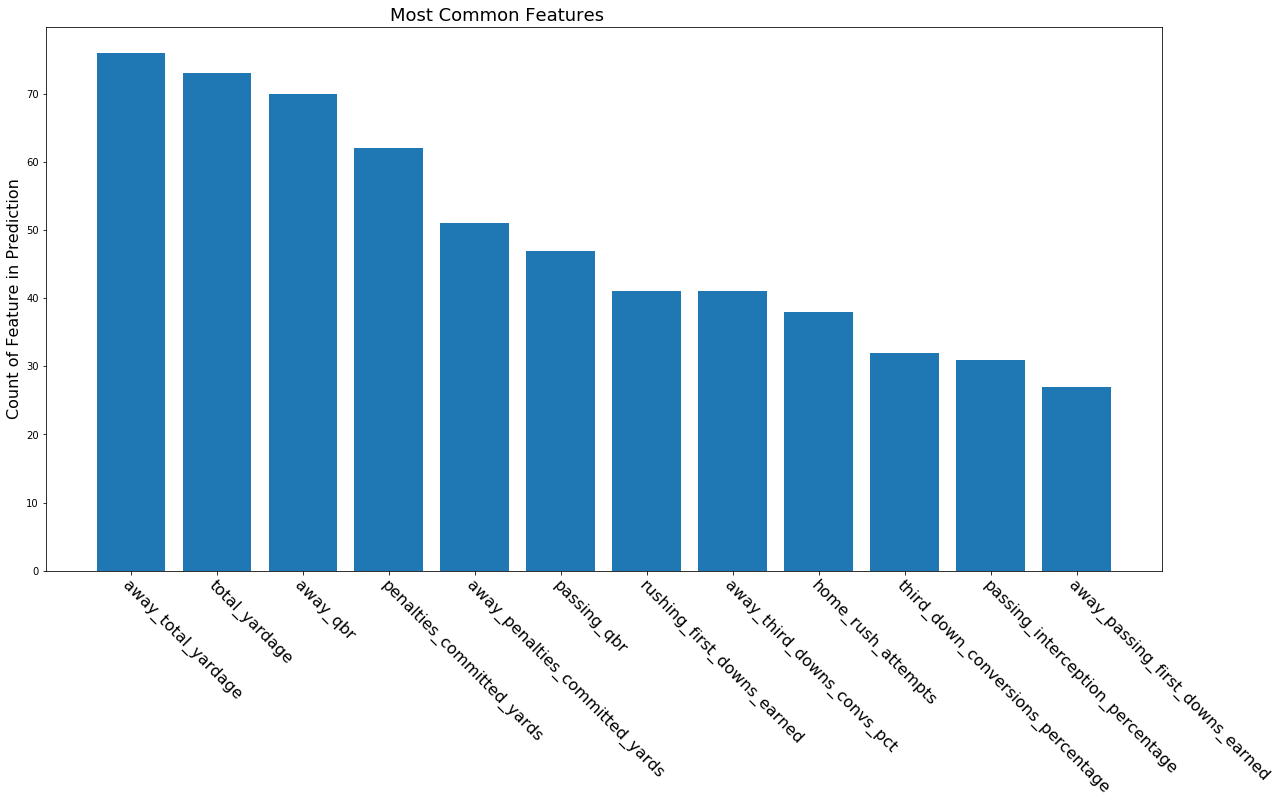

In [35]:
# Get unique items & counts
unique_values = to_1D(predictiondf["feature_names"]).value_counts().index.tolist()
unique_value_counts = to_1D(predictiondf["feature_names"]).value_counts().values
unique_value_counts = unique_value_counts[unique_value_counts > 26]
# Create plot
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(names2, unique_value_counts)
#ax.xticks(rotation = 45)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor", size = 16) 
ax.set_ylabel("Count of Feature in Prediction", size = 16)
ax.set_title("Most Common Features", horizontalalignment='right', size = 18)

In [18]:
unique_value_counts[unique_value_counts > 26]

array([76, 73, 70, 62, 51, 47, 41, 41, 38, 32, 31, 27])

In [16]:
    
names2 = ['away_total_yardage',
 'total_yardage',
 'away_qbr',
 'penalties_committed_yards',
 'away_penalties_committed_yards',
 'passing_qbr',
 'rushing_first_downs_earned',
 'away_third_downs_convs_pct',
 'home_rush_attempts',
 'third_down_conversions_percentage',
 'passing_interception_percentage',
 'away_passing_first_downs_earned']



In [78]:
unique_values

['away_total_yardage',
 'total_yardage',
 'away_qbr',
 'penalties_committed_yards',
 'away_penalties_committed_yards',
 'passing_qbr',
 'rushing_first_downs_earned',
 'away_third_downs_convs_pct',
 'home_rush_attempts',
 'third_down_conversions_percentage',
 'passing_interception_percentage',
 'away_passing_first_downs_earned',
 'away_pass_int_pct',
 'away_pass_comp_pct',
 'passing_completion_percentage',
 'away_rush_attempts',
 'away_fourth_down_attempts',
 'turnovers',
 'away_punts',
 'defensive_plays',
 'home_punts',
 'away_rush_first_downs_earned',
 'penalty_first_downs_earned',
 'away_touchdowns',
 'passing_first_downs_earned',
 'offensive_plays',
 'touchdowns_scored',
 'away_avg_return_touchdowns',
 'away_defensive_plays',
 'fourth_down_attempts',
 'away_pass_net_yards_per_attempt',
 'away_turnovers',
 'passing_net_yards_per_attempt',
 'passing_yards_per_attempt',
 'away_pass_per_attempt',
 'home_avg_return_touchdowns',
 'rushing_yards_per_attempt',
 'field_goals_made',
 'away_fi

In [48]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [69]:
features_bool = boolean_df(
  item_lists = predictiondf["feature_names"],
  unique_items = unique_values
)

In [58]:
features_bool

,away_total_yardage,total_yardage,away_qbr,penalties_committed_yards,away_penalties_committed_yards,passing_qbr,rushing_first_downs_earned,away_third_downs_convs_pct,home_rush_attempts,third_down_conversions_percentage,...,away_field_goals,field_goals_made,rushing_yards_per_attempt,defensive_yards_per_play,away_penalty_first_downs_earned,away_offensive_plays,away_def_yards_per_play,offensive_yards_per_play,away_off_yards_per_play,away_rush_yards_per_attempt
0,False,False,False,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,False,True,True,True,True,...,False,False,False,False,True,True,False,False,False,False
4,True,False,True,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,True,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
93,True,True,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
94,True,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
95,True,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [63]:
features_corr = features_bool.corr(method = "pearson")
features_corr

,away_total_yardage,total_yardage,away_qbr,penalties_committed_yards,away_penalties_committed_yards,passing_qbr,rushing_first_downs_earned,away_third_downs_convs_pct,home_rush_attempts,third_down_conversions_percentage,...,away_field_goals,field_goals_made,rushing_yards_per_attempt,defensive_yards_per_play,away_penalty_first_downs_earned,away_offensive_plays,away_def_yards_per_play,offensive_yards_per_play,away_off_yards_per_play,away_rush_yards_per_attempt
away_total_yardage,1.000000,0.162662,0.511288,0.074154,0.152455,0.108951,0.348436,0.297764,0.319303,0.155873,...,0.187997,0.187997,0.187997,0.178215,0.178215,0.178215,0.168106,0.168106,0.157599,0.146599
total_yardage,0.162662,1.000000,0.176953,0.215916,0.029595,0.412500,0.200435,0.200435,0.068621,0.300686,...,0.129719,0.129719,0.205065,0.115827,0.115827,0.194395,0.183368,0.101022,0.171907,0.159909
away_qbr,0.511288,0.176953,1.000000,0.060242,0.101154,0.233928,0.298589,0.438282,0.121448,0.044383,...,0.149573,0.077030,0.149573,0.134914,0.210559,0.210559,0.119333,0.198615,0.186201,0.173205
penalties_committed_yards,0.074154,0.215916,0.060242,1.000000,0.490186,0.427773,0.295236,0.121410,0.075259,0.253233,...,0.201010,0.268711,0.201010,0.184133,0.184133,0.254729,0.240280,0.166289,0.225262,0.209540
away_penalties_committed_yards,0.152455,0.029595,0.101154,0.490186,1.000000,0.218484,0.478270,0.227501,0.381528,0.534631,...,0.274545,0.339657,0.339657,0.254087,0.321984,0.321984,0.303720,0.303720,0.284737,0.264863
passing_qbr,0.108951,0.412500,0.233928,0.427773,0.218484,1.000000,0.339670,0.005597,0.236128,0.328828,...,0.173708,0.303822,0.368878,0.214007,0.146168,0.281846,0.329850,0.187648,0.309233,0.287650
rushing_first_downs_earned,0.348436,0.200435,0.298589,0.295236,0.478270,0.339670,1.000000,0.239547,0.724159,0.331757,...,0.352157,0.352157,0.417974,0.396226,0.396226,0.396226,0.373751,0.373751,0.350390,0.325934
away_third_downs_convs_pct,0.297764,0.200435,0.438282,0.121410,0.227501,0.005597,0.239547,1.000000,0.125615,0.154210,...,0.352157,0.154705,0.220522,0.258962,0.258962,0.327594,0.229886,0.301819,0.350390,0.245282
home_rush_attempts,0.319303,0.068621,0.121448,0.075259,0.381528,0.236128,0.724159,0.125615,1.000000,0.245429,...,0.379032,0.312427,0.445637,0.422449,0.422449,0.422449,0.398487,0.398487,0.373580,0.347506
third_down_conversions_percentage,0.155873,0.300686,0.044383,0.253233,0.534631,0.328828,0.331757,0.154210,0.245429,1.000000,...,0.371416,0.371416,0.440566,0.266872,0.411087,0.194765,0.380212,0.380212,0.347591,0.397475


In [75]:
features_int = features_bool.astype(int)

In [76]:
features_freq_mat = np.dot(features_int.T, features_int)

In [77]:
features_freq_mat

array([[76, 60, 64, ...,  9,  8,  7],
       [60, 73, 56, ...,  8,  8,  7],
       [64, 56, 70, ...,  9,  8,  7],
       ...,
       [ 9,  8,  9, ...,  9,  7,  5],
       [ 8,  8,  8, ...,  7,  8,  6],
       [ 7,  7,  7, ...,  5,  6,  7]])

In [78]:
features_freq = pd.DataFrame(
    features_freq_mat,
    columns = unique_items.keys(),
    index = unique_items.keys()
)

AttributeError: 'list' object has no attribute 'keys'

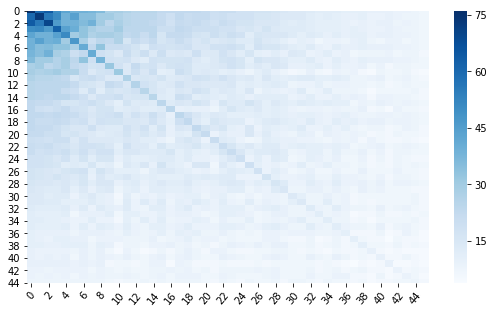

In [79]:
import seaborn as sn
fig, ax = plt.subplots(figsize = (9,5))
sn.heatmap(features_freq_mat, cmap = "Blues")
plt.xticks(rotation=50)
plt.savefig("heatmap.png", dpi = 300)